In [21]:
import math

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import os

In [7]:
data = pd.read_csv('./extract_seoul.csv')

In [9]:
data = data.drop(['Unnamed: 0'],1)

In [10]:
data['Date'] = pd.to_datetime(data['Date'])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 30 columns):
Date               188 non-null datetime64[ns]
Total              188 non-null float64
Seoul              188 non-null float64
Northern seoul     188 non-null float64
Gangbuk-gu         188 non-null float64
Gwangjin-gu        188 non-null float64
Nowon-gu           188 non-null float64
Dobong-gu          188 non-null float64
Dongdaemun-gu      188 non-null float64
Mapo-gu            188 non-null float64
Seodaemun-gu       188 non-null float64
Seongdong-gu       188 non-null float64
Seongbuk-gu        188 non-null float64
Yongsan-gu         188 non-null float64
Eunpyeong-gu       188 non-null float64
Jongno-gu          188 non-null float64
Jung-gu            188 non-null float64
Jungnang-gu        188 non-null float64
Southern Seoul     188 non-null float64
Gangnam-gu         188 non-null float64
Gangdong-gu        188 non-null float64
Gangseo-gu         188 non-null float64
Gwanak-g

In [12]:
GU_ENG_NAME = ''

### Dict 관련 함수 선언

In [13]:
def create_dict(a, b):
    d = dict()
    #갯수 다르면
    if len(a)-len(b) != 0:
        for i in range(len(a)-len(b)):
            b.append(None)
    #갯수 같으면
    for j in range(len(a)):
        d[a[j]] = b[j]
    return d

In [14]:
def find_val_using_key(dic, key):
    if key in dic:
        return dic[key]
    else:
        print('404 not found')
        return dic['서울']

In [15]:
def find_key_using_val(dic, val):
    return [k for k, v in dic.items() if v == val][0]

### 원하는 구만 선택하기

In [16]:
def select_gu_data(df, gu_name):
    gu_name += '-gu'
    global GU_ENG_NAME
    
    GU_ENG_NAME = gu_name
    
    return df[['Date', gu_name]]
    

In [17]:
BASE_PATH = './TimeSeries/'
MODEL_NAME = 'LSTM'

In [19]:
gangnam = select_gu_data(data, 'Gangnam')
print(GU_ENG_NAME)

Gangnam-gu


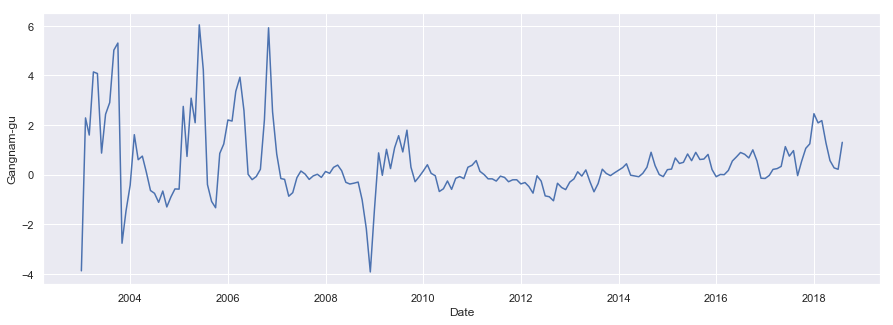

In [20]:
plt.figure(figsize = (15, 5))
ax = sns.lineplot(x="Date", y=GU_ENG_NAME, data=gangnam)

### Keras import

In [22]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [23]:
gangnam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
Date          188 non-null datetime64[ns]
Gangnam-gu    188 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB


In [24]:
mask = pd.to_datetime('2010-01-01')
tmp = gangnam.loc[:][gangnam['Date'] >= mask]

In [25]:
gangnam_tmp = tmp.drop('Date', 1)

In [26]:
gangnam_tmp

,Gangnam-gu
84,0.146998
85,0.401215
86,0.054086
87,-0.042543
88,-0.678413
89,-0.567626
90,-0.254231
91,-0.591100
92,-0.146213
93,-0.075991


### Normalize

In [437]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(gangnam_tmp)

In [438]:
dataset[:5]

array([[0.34161309],
       [0.41399694],
       [0.31515787],
       [0.28764442],
       [0.10659095]])

In [439]:
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (83, 21)


In [440]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [441]:
window_size = 4

In [442]:
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

whole_X, whole_Y = create_dataset(dataset, window_size)
print("Original training data shape:")
print(whole_X.shape)
print(whole_Y.shape)

Original training data shape:
(99, 4)
(99,)


In [443]:
train_Y[:10]

array([0.10659095, 0.13813561, 0.22736977, 0.13145184, 0.25812596,
       0.27812051, 0.25453416, 0.38518202, 0.40807148, 0.4620269 ])

In [444]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
whole_X = np.reshape(whole_X, (whole_X.shape[0], 1, whole_X.shape[1]))

print("New training data shape:")
print(train_X.shape)

New training data shape:
(78, 1, 4)


In [445]:
MODEL_PATH = ''


if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)

def create_checkpoint(model_name):
    global MODEL_PATH
    MODEL_PATH = os.path.join(BASE_PATH, model_name)
    print("Model_path : ", MODEL_PATH)
    
    MODEL_PATH = MODEL_PATH + "/" + GU_ENG_NAME
    
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    
    return ModelCheckpoint(filepath=os.path.join(MODEL_PATH, 'val_loss-{val_loss:.6f}.hdf5'),
                           monitor='val_loss',
                           verbose=1,
                           save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

In [509]:
def Model(train_X, train_Y, window_size = 1):
    model = Sequential()
    model.add(LSTM(12,return_sequences=True, input_shape = (1, window_size)))
    model.add(LSTM(12,return_sequences=True))
    model.add(LSTM(12))
    model.add(Dense(1))
    
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=True)
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    model.compile(loss = "mean_squared_error", 
                  optimizer = adam)

    model.summary()
    
    checkloss = create_checkpoint(MODEL_NAME)
    
    history = model.fit(train_X, train_Y, epochs = 500 ,batch_size=4, validation_split = 0.1,
                        shuffle=True,
                        callbacks=[checkloss, early_stopping])
    
    return model, history

In [510]:
model = Model(train_X, train_Y, window_size)

Model_path :  ./TimeSeries/LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 1, 12)             816       
_________________________________________________________________
lstm_38 (LSTM)               (None, 12)                1200      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 13        
Total params: 2,029
Trainable params: 2,029
Non-trainable params: 0
_________________________________________________________________
Model_path :  ./TimeSeries/LSTM
Train on 70 samples, validate on 8 samples
Epoch 1/500
70/70 [==============================] - 4s 60ms/step - loss: 0.0859 - val_loss: 0.1880

Epoch 00001: val_loss improved from inf to 0.18796, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.187956.hdf5
Epoch 2/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0

70/70 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0166

Epoch 00037: val_loss did not improve from 0.01571
Epoch 38/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0167

Epoch 00038: val_loss did not improve from 0.01571
Epoch 39/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0157

Epoch 00039: val_loss improved from 0.01571 to 0.01568, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.015682.hdf5
Epoch 40/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0149

Epoch 00040: val_loss improved from 0.01568 to 0.01492, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.014921.hdf5
Epoch 41/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0161

Epoch 00041: val_loss did not improve from 0.01492
Epoch 42/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0137

Epoch 

Epoch 85/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0107

Epoch 00085: val_loss did not improve from 0.00904
Epoch 86/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0084

Epoch 00086: val_loss improved from 0.00904 to 0.00843, saving model to ./TimeSeries/LSTM/Gangnam-gu/val_loss-0.008432.hdf5
Epoch 87/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0097

Epoch 00087: val_loss did not improve from 0.00843
Epoch 88/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0100

Epoch 00088: val_loss did not improve from 0.00843
Epoch 89/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0088

Epoch 00089: val_loss did not improve from 0.00843
Epoch 90/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0105

Epoch 00090: val_loss did not improve from 0.00843
Epoch 91/500
70

70/70 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0092

Epoch 00136: val_loss did not improve from 0.00674
Epoch 137/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0077

Epoch 00137: val_loss did not improve from 0.00674
Epoch 138/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0078

Epoch 00138: val_loss did not improve from 0.00674
Epoch 139/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0087

Epoch 00139: val_loss did not improve from 0.00674
Epoch 140/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0078

Epoch 00140: val_loss did not improve from 0.00674
Epoch 141/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0084

Epoch 00141: val_loss did not improve from 0.00674
Epoch 142/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.

70/70 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0064

Epoch 00188: val_loss did not improve from 0.00634
Epoch 189/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0075

Epoch 00189: val_loss did not improve from 0.00634
Epoch 190/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0073

Epoch 00190: val_loss did not improve from 0.00634
Epoch 191/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0069

Epoch 00191: val_loss did not improve from 0.00634
Epoch 192/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0068

Epoch 00192: val_loss did not improve from 0.00634
Epoch 193/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0076

Epoch 00193: val_loss did not improve from 0.00634
Epoch 194/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.

70/70 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0074

Epoch 00241: val_loss did not improve from 0.00618
Epoch 242/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0072

Epoch 00242: val_loss did not improve from 0.00618
Epoch 243/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0067

Epoch 00243: val_loss did not improve from 0.00618
Epoch 244/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0083

Epoch 00244: val_loss did not improve from 0.00618
Epoch 245/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0062

Epoch 00245: val_loss did not improve from 0.00618
Epoch 246/500
70/70 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0071

Epoch 00246: val_loss did not improve from 0.00618
Epoch 247/500
70/70 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.

In [511]:
def predict_and_score(model, X, Y):
    pred = scaler.inverse_transform(model.predict(X))
    # 0 ~ 1 inverse origin
    orig_data = scaler.inverse_transform([Y])
    
    print(len(orig_data[0]))
    print(len(pred[:, 0]))
    
    #RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, orig_data)

In [512]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [513]:
rmse_train, train_predict, train_orig = predict_and_score(model[0], train_X, train_Y)
rmse_test, test_predict, test_orig = predict_and_score(model[0], test_X, test_Y)

whole_test, whole_predict, whole_orig = predict_and_score(model[0], whole_X, whole_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
print("Whole data score: %.2f RMSE " % whole_test)

78
78
16
16
99
99
Training data score: 0.29 RMSE
Test data score: 0.61 RMSE
Whole data score: 0.36 RMSE 


In [514]:
mean_absolute_percentage_error(whole_orig[0], whole_predict[:, 0])

1067.89293363349

In [515]:
def start_predict_n_plot(dataset, train_predict, test_predict):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    
    ##땡기자
    print("window_size: ", window_size)
    train_predict_plot[(window_size - 1) : len(train_predict) + (window_size - 1)] = train_predict

    
    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
#     test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1] = test_predict
    test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict
    
    print(test_predict_plot.shape)
    print(whole_predict.shape)

    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(train_predict_plot, label = "Training set pred")
    plt.plot(test_predict_plot, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()

window_size:  4
(104, 1)
(99, 1)


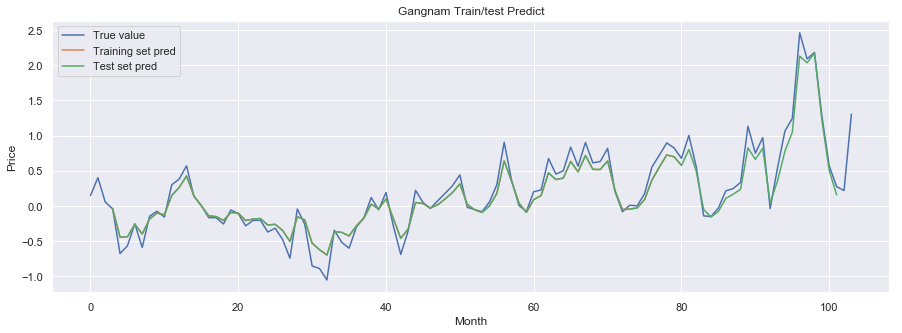

In [516]:
start_predict_n_plot(dataset, train_predict, test_predict)

In [517]:
len(train_X)

78

In [518]:
len(whole_predict)

99

In [519]:
whole_predict[-window_size:].shape

(4, 1)

In [520]:
whole_predict[-window_size:]

array([[2.1721742 ],
       [1.2247128 ],
       [0.5008342 ],
       [0.15730432]], dtype=float32)

In [521]:
def predict_future(model, X, window_size):
    
    print('X shape: ', X.shape)
    
    trans = X[-window_size:].T
    
    print("trans: ", trans)
    print("trans shape: ", trans.shape)
    
    
    tmp_shape = np.reshape(trans, (trans.shape[0], 1, trans.shape[1]))
    print("tmp_shape: ", tmp_shape)
    pred = model.predict(tmp_shape)
    print("pred: ", pred)
    
#     print(pred[0])
    return pred

In [522]:
len(whole_predict)

99

In [523]:
future_pred = predict_future(model[0], whole_predict, window_size)

X shape:  (99, 1)
trans:  [[2.1721742  1.2247128  0.5008342  0.15730432]]
trans shape:  (1, 4)
tmp_shape:  [[[2.1721742  1.2247128  0.5008342  0.15730432]]]
pred:  [[0.05843775]]


In [524]:
whole_predict = np.append(whole_predict, future_pred, axis=0)

In [525]:
for i in range(10):
    print("len before: ", len(whole_predict))
    future_pred = predict_future(model[0], whole_predict, window_size)
    
    print("future_pred")
    print(future_pred)
    whole_predict = np.append(whole_predict, future_pred, axis=0)

len before:  100
X shape:  (100, 1)
trans:  [[1.2247128  0.5008342  0.15730432 0.05843775]]
trans shape:  (1, 4)
tmp_shape:  [[[1.2247128  0.5008342  0.15730432 0.05843775]]]
pred:  [[0.0922517]]
future_pred
[[0.0922517]]
len before:  101
X shape:  (101, 1)
trans:  [[0.5008342  0.15730432 0.05843775 0.0922517 ]]
trans shape:  (1, 4)
tmp_shape:  [[[0.5008342  0.15730432 0.05843775 0.0922517 ]]]
pred:  [[0.13965909]]
future_pred
[[0.13965909]]
len before:  102
X shape:  (102, 1)
trans:  [[0.15730432 0.05843775 0.0922517  0.13965909]]
trans shape:  (1, 4)
tmp_shape:  [[[0.15730432 0.05843775 0.0922517  0.13965909]]]
pred:  [[0.17365219]]
future_pred
[[0.17365219]]
len before:  103
X shape:  (103, 1)
trans:  [[0.05843775 0.0922517  0.13965909 0.17365219]]
trans shape:  (1, 4)
tmp_shape:  [[[0.05843775 0.0922517  0.13965909 0.17365219]]]
pred:  [[0.19808656]]
future_pred
[[0.19808656]]
len before:  104
X shape:  (104, 1)
trans:  [[0.0922517  0.13965909 0.17365219 0.19808656]]
trans shape:  

In [526]:
whole_predict

array([[-3.71412821e-02],
       [-4.44732457e-01],
       [-4.39091682e-01],
       [-2.61626631e-01],
       [-3.99145365e-01],
       [-1.86658531e-01],
       [-1.01609752e-01],
       [-1.26882881e-01],
       [ 1.48181811e-01],
       [ 2.61160314e-01],
       [ 4.24739182e-01],
       [ 1.41041294e-01],
       [ 1.47013762e-03],
       [-1.40892729e-01],
       [-1.51854441e-01],
       [-2.06336230e-01],
       [-9.47607309e-02],
       [-1.03533857e-01],
       [-2.08173975e-01],
       [-1.87334418e-01],
       [-1.79713324e-01],
       [-2.72488803e-01],
       [-2.62042254e-01],
       [-3.48681033e-01],
       [-5.05215526e-01],
       [-1.54511943e-01],
       [-1.97838113e-01],
       [-5.30988395e-01],
       [-6.22547925e-01],
       [-6.99785292e-01],
       [-3.66613030e-01],
       [-3.76431346e-01],
       [-4.27103341e-01],
       [-2.83534050e-01],
       [-1.74224496e-01],
       [ 2.44586766e-02],
       [-4.32863086e-02],
       [ 9.86232311e-02],
       [-1.8

In [527]:
def whole_predict_n_plot(dataset, train_predict):
    
    true_value_plot = np.empty_like(dataset)
    print(true_value_plot.shape)
    print(whole_predict.shape)
    
    print('dataset_len : ', len(dataset))
    print('whole_predict_len : ', len(whole_predict))
    
    
#     test_predict_plot[:, :] = np.nan
#     test_predict_plot[(window_size - 1): len(whole_predict) + (window_size - 1), :] = whole_predict

    whole_predict_plot = np.empty_like(dataset)
    whole_predict_plot[:, :] = np.nan
#     whole_predict_plot[(window_size): len(whole_predict) + (window_size), :] = whole_predict
    

    plt.figure(figsize = (15, 5))
    plt.plot(scaler.inverse_transform(dataset), label = "True value")
    plt.plot(whole_predict, label = "Test set pred")
    plt.xlabel("Month")
    plt.ylabel("Price")
    plt.title("Gangnam Train/test Predict")
    plt.legend()
    plt.show()

(104, 1)
(110, 1)
dataset_len :  104
whole_predict_len :  110


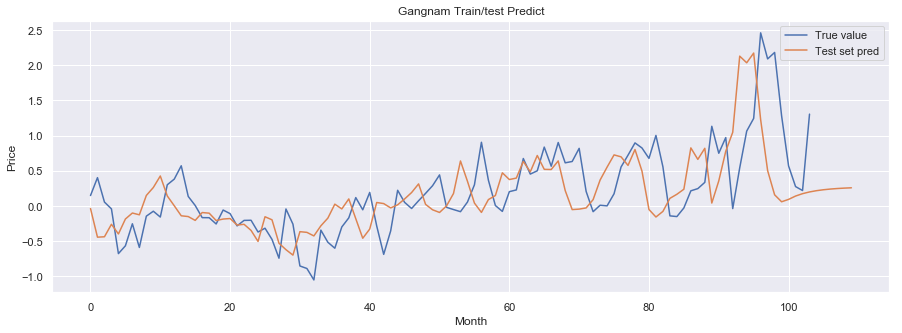

In [528]:
whole_predict_n_plot(dataset, train_predict)

(104, 1)
(110, 1)
dataset_len :  104
whole_predict_len :  110


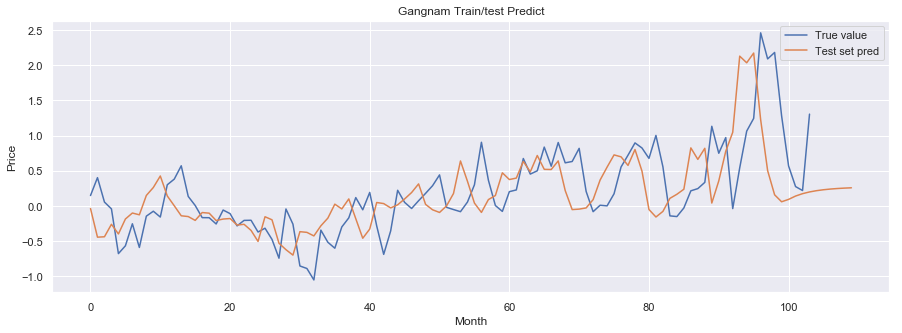

In [529]:
whole_predict_n_plot(dataset, train_predict)